In [ ]:
#!git clone https://github.com/tbchhetri/DrivingData #use ! to invoke bash commands to use commands like ls cd git clone, these can just be used as a command line

fatal: destination path 'DrivingData' already exists and is not an empty directory.


In [ ]:
from google.colab import drive #details: https://youtu.be/InZ16tcM9Pc, https://youtu.be/58t0PFIWR9Y
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa #https://imgaug.readthedocs.io/en/latest/
import cv2
import pandas as pd
import ntpath #to cut the path  
import random

In [ ]:
#getting the data from the git and save it in a var
#gitData = "DrivingData"
gitData = r'/content/drive/MyDrive/DrivingData'
columns = ['center','steering', 'speed'] #inref to the csv file
drivingData = pd.read_csv(os.path.join(gitData, 'driving_log.csv'), names = columns)
drivingData.head()

,center,steering,speed
0,/Volumes/MyData/Data/College/Winter20/training...,0.0,0.000077
1,/Volumes/MyData/Data/College/Winter20/training...,0.0,0.000079
2,/Volumes/MyData/Data/College/Winter20/training...,0.0,0.000079
3,/Volumes/MyData/Data/College/Winter20/training...,0.0,0.000079
4,/Volumes/MyData/Data/College/Winter20/training...,0.0,0.000080


In [ ]:
#remove the startin path of images
def getTail(imgPath):
  _,tail = ntpath.split(imgPath)
  return tail 

#moving forward we will only be using center data as our camera will only be placed at the center of the car
drivingData['center'] = drivingData['center'].apply(getTail) #same can be done for left and right
#drivingData.head()

In [ ]:
#getting rid of excess data so that our model will not be biased
numBins = 25
deleteMe = []
binElemets = 400 #so only 400 elements per bin
_, bins = np.histogram(drivingData['steering'], numBins)

for binCounter in range (numBins):
  tempList = [] #get the list ready for another bin
  for steeringIndex in range(len(drivingData['steering'])):
    if drivingData['steering'][steeringIndex] >= bins[binCounter] and drivingData['steering'][steeringIndex] <= bins[binCounter+1]: #making sure the steering falls in the bins
      tempList.append(steeringIndex)
  tempList = shuffle(tempList)
  tempList = tempList[binElemets:]
  deleteMe.extend(tempList) #deleteMe will now contain all the excess steering data

drivingData.drop(drivingData.index[deleteMe], inplace=True) #data is removed here, true inplace removes the data directly from the drivingData without returning anything

In [ ]:
#getting the training data and labels
def getReadyImg(gitData): #returns the center image and it's corresponding steering angle
  imgPath = []
  steering  = []

  for row in range (len(drivingData)):
    drivingDataRow = drivingData.iloc[row]
    imgPath.append(os.path.join(gitData, drivingDataRow[0].strip())) #center = drivingDataRow[0]
    steering.append(float(drivingDataRow[1])) #cuz steering is at index 1

  return imgPath, steering
imgPath, steeringDegree = getReadyImg(gitData + '/IMG')

X_train, X_val, y_train, y_val = train_test_split(imgPath, steeringDegree, test_size = 0.2, random_state = 6) #20%of data will be x_val and y_val

In [ ]:
# AUGMENTATION TECHNIQUES
#1. Zoom
def zoom(img):
  zoom = iaa.Affine(scale=(1,1.3)) #selects a random percent of zoom from 1-30%
  img = zoom.augment_image(img)
  return img

#2. Panning
#def panIt(img):
#  pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y" : (-0.1, 0.1)}) #just the degree of panning, it is working randomly
#  img = pan.augment_image(img)
#  return img

#3. Brightness
def brighten (img):
  brightness = iaa.Multiply((0.2,1.2)) #makes img darker if less than 1, it is working randomly
  img = brightness.augment_image(img)
  return img

#4. Flip
def flip (img, steeringDegree):
  flipped = cv2.flip(img, 1) #1-horizontal flip, -1-vertical flip
  steeringDegree = -steeringDegree
  return flipped, steeringDegree

#COMBINING AUGMENTATIONS
def randomAugmentation (img, steeringDegree):
  img = mpimg.imread(img) #reading the image path

  if (np.random.rand() < 0.5): #this will only run almost half of the time, the rand function only outputs no from 0-1
    img = zoom(img)
  #if (np.random.rand() < 0.5):
  #  img = panIt(img)
  if (np.random.rand() < 0.5):
    img = brighten(img)
  if (np.random.rand() < 0.5):
    img, steeringDegree = flip(img, steeringDegree)
  
  return img, steeringDegree

In [ ]:
#PREPROCESSING
def preprocess(img):
  #img = mpimg.imread(img)
  img = img[60:135,:,:] #we are cropping the height of the image since other than 60-135 we dont need those infos
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV) #Y-luminosity, and UV. This is recommended by NVIDIA while running their Neural Network
  img = cv2.GaussianBlur(img, (3,3), 0) #(3,3) is the kernal size for the blur, this is done to reduce the noise in image
  img = cv2.resize(img, (200,66)) #this size is also recommended by NVIDIA
  img = img/255
  return img

In [ ]:
def augmenterCoroutein (imgPath, steeringDegree, batchSize, isTraining):#this is a coroutein, when this is called again the values don't reinitialize but gets initialized to their old value
  while True: #coroutines can pause and resume thier functions
    imgBatch = []
    steeringBatch = []

    for counter in range (batchSize):
      randomIndex = random.randint(0, len(imgPath) - 1)

      if isTraining:
        img, steering = randomAugmentation(imgPath[randomIndex], steeringDegree[randomIndex])
      else:
        img = mpimg.imread(imgPath[randomIndex])
        steering = steeringDegree[randomIndex]
      
      img = preprocess(img)
      imgBatch.append(img)
      steeringBatch.append(steering)
    yield (np.asarray(imgBatch), np.asarray(steeringBatch))

In [ ]:
#following the NVIDIA Model, more details: https://developer.nvidia.com/blog/deep-learning-self-driving-cars/
def nvidiaModel():
  model = Sequential()
  model.add(Convolution2D(24, (5, 5), strides=(2,2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Convolution2D(36, (5, 5), strides=(2,2), activation='elu'))
  model.add(Convolution2D(48, (5, 5), strides=(2,2), activation='elu'))
  model.add(Convolution2D(64, (3, 3), activation='elu'))
  
  model.add(Convolution2D(64, (3, 3), activation='elu'))
  #model.add(Dropout(0.5))
  
  model.add(Flatten())
  
  model.add(Dense(100, activation = 'elu'))
  #model.add(Dropout(0.5))
  
  model.add(Dense(50, activation = 'elu'))
  #model.add(Dropout(0.5))
  
  model.add(Dense(10, activation = 'elu'))
  #model.add(Dropout(0.5))

  model.add(Dense(1))
  
  model.compile(loss='mse', optimizer = Adam(lr=1e-4))
  return model

In [ ]:
model = nvidiaModel()   
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               1

In [ ]:
history = model.fit_generator(augmenterCoroutein(X_train, y_train, 100, 1), steps_per_epoch = 300, epochs = 10, 
                              validation_data = augmenterCoroutein(X_val, y_val, 100, 0), validation_steps = 200, verbose = 1, shuffle = 1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
300/300 [==============================] - 638s 2s/step - loss: 0.1246 - val_loss: 0.1104
Epoch 2/10
300/300 [==============================] - 217s 726ms/step - loss: 0.0997 - val_loss: 0.0766
Epoch 3/10
300/300 [==============================] - 217s 725ms/step - loss: 0.0861 - val_loss: 0.0564
Epoch 4/10
300/300 [==============================] - 214s 717ms/step - loss: 0.0762 - val_loss: 0.0526
Epoch 5/10
300/300 [==============================] - 219s 733ms/step - loss: 0.0672 - val_loss: 0.0470
Epoch 6/10
300/300 [==============================] - 222s 742ms/step - loss: 0.0596 - val_loss: 0.0437
Epoch 7/10
300/300 [==============================] - 221s 739ms/step - loss: 0.0594 - val_loss: 0.0538
Epoch 8/10
300/300 [==============================] - 220s 737ms/step - loss: 0.0530 - val_loss: 0.0396
Epoch 9/10
300/300 [==============================] - 219s 731ms/step - loss: 0.0489 - val_loss: 0.0413
Epoch 10/10
300/300 [==============================] - 216s 722ms/s

Text(0.5, 0, 'epoch')

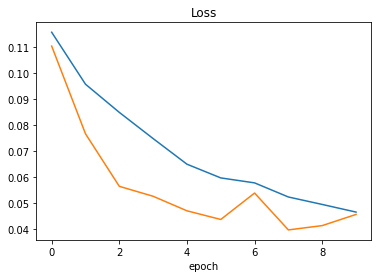

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')